In [77]:
import os
import cv2 
from os import listdir
import csv
from sklearn.cluster import KMeans
import numpy as np
import random
import matplotlib.pyplot as pyplot
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import joblib


In [10]:
# to load the data sampels enter the pathes of the folders

back='/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/'
inner='/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/inner_cell/'
outer='/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/outer_cell/'

backa = []  
            
for dirName, subdirList, fileList in os.walk(back):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            namedir=[os.path.splitext(filename)[0],os.path.join(dirName,filename)]
            backa.append(namedir)

outera = []  # create an empty list

for dirName, subdirList, fileList in os.walk(outer):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            namedir=[os.path.splitext(filename)[0],os.path.join(dirName,filename)]
            outera.append(namedir)
            
innera = []  # create an empty list

for dirName, subdirList, fileList in os.walk(inner):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            namedir=[os.path.splitext(filename)[0],os.path.join(dirName,filename)]
            innera.append(namedir)



In [11]:
#Generate the labels for each data sample(background,inner_cell,outer_cell)
#we insert the pixels in order each data sample grouped together
#with each pixel read we insert a label of (0) if it is background,(1) if it is outer_cell,(2) if it is inner_cell
#generate pixel_list(X_Train) during each itration from different data sample (background,inner_cell,outer_cell)
pixel_list=[]
Labels = [ ]
dim=(65,65)
for i in range(len(backa)):
    img = cv2.imread(backa[i][1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img=img.reshape(-1,3)     
    for i in img:
        pixel_list.append(i/255)
        Labels.append(0)

for i in range(len(outera)):
    img = cv2.imread(outera[i][1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img=img.reshape(-1,3)     
    for i in img:
        pixel_list.append(i/255)
        Labels.append(1)

for i in range(len(innera)):
    img = cv2.imread(innera[i][1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img=img.reshape(-1,3)     
    for i in img:
        pixel_list.append(i/255)
        Labels.append(2)



[['001', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/001.JPG'], ['002', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/002.JPG'], ['003', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/003.JPG'], ['004', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/004.JPG'], ['005', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/005.JPG'], ['006', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/006.JPG'], ['007', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_Segmentation-20210525T001752Z-001/SVM_Segmentation/background/007.JPG'], ['008', '/Users/User/Desktop/Pattern Recognition/Midterm/SVM_

In [66]:
#Binarizing the data with output 0,1 for labels
import numpy as np
labels = Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
Y_label=lb.transform(labels)

(380250, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [74]:
class SavModel:
    #take X-data and get the max along axis 0
    def relu_activation(self,data):
        return np.maximum(data,0)
    #softmax output y_pred 
    def softmax(self,A):
        expA = np.exp(A)
        return expA / expA.sum(axis=1, keepdims=True)
    #cross_entropy_softmax_loss_array calculate loss 
    def cross_entropy_softmax_loss_array(self,softmax_probs_array, y_onehot):
        indices = np.argmax(y_onehot, axis = 1).astype(int)
        predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
        log_preds = np.log(predicted_probability)
        loss = -1.0 * np.sum(log_preds) / len(log_preds)
        return loss

    def regularization_L2_softmax_loss(self,reg_lambda, weight1, weight2):
        weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
        weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
        return weight1_loss + weight2_loss

    #to predict y and output y_pred 
    def Predict(self,x_test):
        
        input_layer = np.dot(x_test, self.layer1_weights_array)
        hidden_layer = self.relu_activation(input_layer + self.layer1_biases_array)
        scores = np.dot(hidden_layer, self.layer2_weights_array) + self.layer2_biases_array
        probs = self.softmax(scores)
        
        y_pred=np.argmax(probs, axis = 1)
        
        return y_pred
    #trining the data
    def Train(self,x,y):
        
        training_data=x
        training_labels=y

        hidden_nodes = 11
        num_features = training_data.shape[1]
        num_labels = training_labels.shape[1]

        self.layer1_weights_array = np.random.randn(num_features, hidden_nodes) 
        self.layer1_biases_array = np.zeros((1, hidden_nodes))

        self.layer2_weights_array = np.random.randn(hidden_nodes, num_labels) 
        self.layer2_biases_array = np.zeros((1, num_labels))

        learning_rate = 0.5
        reg_lambda = 0.01
        
        for step in range(50):

            input_layer = np.dot(training_data, self.layer1_weights_array)
            hidden_layer = self.relu_activation(input_layer + self.layer1_biases_array)
            output_layer = np.dot(hidden_layer, self.layer2_weights_array) + self.layer2_biases_array
            output_probs = self.softmax(output_layer)

            loss = self.cross_entropy_softmax_loss_array(output_probs, training_labels)
            loss += self.regularization_L2_softmax_loss(reg_lambda, self.layer1_weights_array, self.layer2_weights_array)

            output_error_signal = (output_probs - training_labels) / output_probs.shape[0]

            error_signal_hidden = np.dot(output_error_signal, self.layer2_weights_array.T) 
            error_signal_hidden[hidden_layer <= 0] = 0

            gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
            gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

            gradient_layer1_weights = np.dot(training_data.T, error_signal_hidden)
            gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

            gradient_layer2_weights += reg_lambda * self.layer2_weights_array
            gradient_layer1_weights += reg_lambda * self.layer1_weights_array

            self.layer1_weights_array -= learning_rate * gradient_layer1_weights
            self.layer1_biases_array -= learning_rate * gradient_layer1_bias
            self.layer2_weights_array -= learning_rate * gradient_layer2_weights
            self.layer2_biases_array -= learning_rate * gradient_layer2_bias

            if step % 30 == 0:
                    print ('Loss at step {0}: {1}'.format(step, loss))

In [68]:
#Test Image
## to load the test image enter the path of the test image
path='/Users/User/Desktop/Pattern Recognition/Midterm/Dataset 1/002.bmp'
img = cv2.imread(path)
list_1=[]

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
xsize=int(img.shape[0])
ysize=int(img.shape[1])
    
img=img.reshape(-1,3)     
for i in img:
    list_1.append(i/255)


(65, 65, 3)
(4225, 3)


In [13]:
pixel_list = np.asarray(pixel_list)

[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 ...
 [0.56862745 0.30196078 0.65882353]
 [0.55294118 0.28235294 0.63921569]
 [0.54117647 0.27058824 0.62745098]]
(380250, 3)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [75]:
#create object from SavModel and predict the data
model=SavModel()
model.Train(pixel_list,Y_label)
y_pred=model.Predict(list_1)

Loss at step 0: 3.107770098633153
Loss at step 30: 0.7768217216769224
[0 0 0 ... 0 0 0]


In [60]:
unique, counts = np.unique(y_pred, return_counts=True, axis = 0)

print (np.asarray((unique, counts)).T)


[[   0 1999]
 [   1 1443]
 [   2  783]]


In [61]:
#checking y_pred values 
#if y_pred=0 take the corresponding pixel in test image and append it in the background list 
#if y_pred=1 take the corresponding pixel in test image and append it in the outer_cell list 
#if y_pred=2 take the corresponding pixel in test image and append it in the inner_cell list 
# then get the mean of these lists
Back_list=[]
inner_list=[]
outer_list=[]

for i in range(len(list_1)):
  
    if(y_pred[i] ==0):
        Back_list.append(list_1[i])
    if(y_pred[i] ==1):
        outer_list.append(list_1[i])
    if(y_pred[i] ==2):
        inner_list.append(list_1[i])
        
    back_pix=np.mean(Back_list, axis=0)
    inner_pix=np.mean(inner_list, axis=0)
    outer_pix=np.mean(outer_list, axis=0)

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


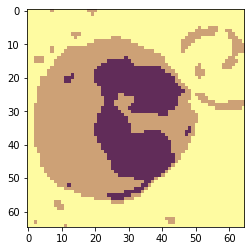

In [76]:
#Draw the output image 

output = np.zeros((xsize,ysize,3),dtype=np.uint8)
inc=0
for i in range(xsize):
    for j in range(ysize):
        if(y_pred[inc]==0):
            output[i,j]=back_pix *255

        if(y_pred[inc]==1):
            output[i,j]= outer_pix *255

        if(y_pred[inc]==2):
            output[i,j]=inner_pix *255

        inc+=1   
            
plt.imshow(output)

In [78]:
#saving model
filename = 'P2_model.sav'
joblib.dump(model, filename)

['P2_model.sav']

In [79]:
#loading model
loaded_model = joblib.load(filename)
loaded_model.Predict(list_1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)